# Ανίχνευση του λιπώδους ιστού με συσταδοποίηση
## Εντοπισμός της θερμικής συμπεριφοράς
### Επιλογή εικόνων για τη μέτρηση της μέσης θερμοκρασίας και της τυπικής απόκλισης
Στο αρχείο bat_list.yml έχουμε ορίσει από ποιες εικόνες θα καταγράψουμε τη μέση θερμοκρασία ενός τετραγωνικού patch το οποίο βρίσκεται στον αυχένα ενός ποντικιού, όπως φαίνεται στην παραπάνω εικόνα. 

Δομή του αρχείου yaml: 
```
samples: [0h, 24h, 48h, 72h, 96h, 120h, 144h, 192h, 240h]
mouse_id: [mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]
mouse_1:
  csv: [CSV_2060.csv, CSV_2305.csv, CSV_2509.csv, CSV_2730.csv, CSV_2957.csv, CSV_3181.csv, CSV_3397.csv, CSV_3652.csv, CSV_3855.csv]
  jpeg: [IR_2060.jpg, IR_2305.jpg, IR_2509.jpg, IR_2730.jpg, IR_2957.jpg, IR_3181.jpg, IR_3397.jpg, IR_3652.jpg, IR_3855.jpg]
.
.
. κλπ
```

In [1]:
import os
import sys
import yaml

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from celluloid import Camera
from IPython.display import HTML # to show the animation in Jupyter
from tqdm import tqdm

from skimage.exposure import histogram
from skimage.filters.rank import entropy
from skimage.morphology import disk, square, skeletonize, thin, dilation
from skimage.util import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from sklearn import cluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from src.features import mouse_detection
from src.features import img_to_vectors
from src.data import data_utils
from sklearn import preprocessing

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

src.data.data_utils


In [2]:
# Εισαγωγή του αρχείου yaml
with open(module_path + '/data/bat_list.yml') as file:
    experiment = yaml.load(file, Loader=yaml.FullLoader)
# access: experiment['samples'], experiment['mouse_id']

In [3]:
samples_sec = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])
display('samples_sec')

samples_sec
      mouse_1  mouse_2  mouse_3  mouse_4  mouse_5
0h          0        9       18       27       36
24h         1       10       19       28       37
48h         2       11       20       29       38
72h         3       12       21       30       39
96h         4       13       22       31       40
120h        5       14       23       32       41
144h        6       15       24       33       42
192h        7       16       25       34       43
240h        8       17       26       35       44

### Κατασκευή global path για τα δεδομένα και απομάκρυνση background 

In [6]:
# Πρόσβαση στα δεδομένα του αρχείου
mouse_names = ['mouse_1', 'mouse_2', 'mouse_3', 'mouse_4', 'mouse_5']
# mouse_names = ['mouse_1']
# Κατασκευή των global path για τα αρχεία του πειράματος
infrared_items = []
csv_items = []
for mouse_name in mouse_names:
    for hour, jpg_file in zip(experiment['samples'], experiment[mouse_name]['jpg']):
        full_jpg_path = f'{module_path}/data/raw/{hour}/{mouse_name}/{jpg_file}'
        infrared_items.append(full_jpeg_path)

    for hour, csv_file in zip(experiment['samples'], experiment[mouse_name]['csv']):
        full_csv_path = f'{module_path}/data/raw/{hour}/{mouse_name}/{csv_file}'
        csv_items.append(full_csv_path)
# Εισαγωγή των δεδομένων με βάση τα path και οι προεπεξεργασίες τους
infrared_images = [] # will store (238, 98), (229, 100) arrays etc
exif_datum = []
for item in infrared_items:
    infrared_image, exif_data = data_utils.IR_fixer(fpath=item)
    infrared_images.append(infrared_image)
    exif_datum.append(exif_data)

markerBack, markerBody = 70, 150

object_images, object_masks, initial_masks, mouse_locations = mouse_detection.mouse_detection(infrared_images, markerBack, markerBody)

csv_files = [] # will store (240, 160) arrays
for item in csv_items:
    csv_files.append(data_utils.CSV_fixer(item))
csv_thermals = [mask * csv for (mask, csv) in zip(initial_masks, csv_files)]
new_csv_thermals = [csv_thermal[mouse_location] for (csv_thermal, mouse_location) in zip(csv_thermals, mouse_locations)]

### Τετραγωνική Περιοχή αυχένα και μέτρηση θερμοκρασίων

18it [00:00, 176.48it/s]

['mouse_1', 'mouse_2', 'mouse_3', 'mouse_4', 'mouse_5']
Body : shape: (220, 97), area: 14778 Mean Temp: 31.42715049397754  Std Temp: 1.5282070112359722
Patch : shape: (17, 30), area: 510 Mean Temp: 31.553754901960787  Std Temp: 1.396424904689384
Body : shape: (230, 99), area: 16829 Mean Temp: 31.572011943668674  Std Temp: 1.543993447420763
Patch : shape: (18, 30), area: 540 Mean Temp: 33.03151851851852  Std Temp: 0.33962650731631555
Body : shape: (218, 95), area: 15808 Mean Temp: 31.743745445344132  Std Temp: 1.152805454574915
Patch : shape: (18, 28), area: 504 Mean Temp: 32.365249999999996  Std Temp: 0.9742357123480362
Body : shape: (236, 105), area: 17859 Mean Temp: 31.12934878772608  Std Temp: 1.3080643963070482
Patch : shape: (19, 32), area: 608 Mean Temp: 32.37919407894737  Std Temp: 0.43037841958431006
Body : shape: (235, 90), area: 15582 Mean Temp: 31.262739057887305  Std Temp: 1.3936206717136046
Patch : shape: (19, 27), area: 513 Mean Temp: 32.61505653021442  Std Temp: 0.551968

45it [00:00, 207.35it/s]


Body : shape: (238, 100), area: 16911 Mean Temp: 31.861586127372718  Std Temp: 1.4353014943392979
Patch : shape: (19, 30), area: 570 Mean Temp: 33.07115438596491  Std Temp: 0.28562476431418765
Body : shape: (234, 121), area: 17991 Mean Temp: 31.922226390973265  Std Temp: 1.6519994264502385
Patch : shape: (19, 36), area: 684 Mean Temp: 33.3336783625731  Std Temp: 0.7605457405376421
Body : shape: (238, 102), area: 17455 Mean Temp: 31.828034431395018  Std Temp: 1.4825451786439843
Patch : shape: (19, 31), area: 589 Mean Temp: 32.91855178268251  Std Temp: 0.5896235017399855
Body : shape: (236, 95), area: 15832 Mean Temp: 32.13978303436079  Std Temp: 1.3844437713194107
Patch : shape: (19, 28), area: 532 Mean Temp: 32.81373872180451  Std Temp: 0.4776710469581819
Body : shape: (238, 101), area: 17390 Mean Temp: 31.691336170212768  Std Temp: 1.5995849740760135
Patch : shape: (19, 30), area: 570 Mean Temp: 32.58754912280702  Std Temp: 0.7185491609554332
Body : shape: (219, 88), area: 14444 Mean 

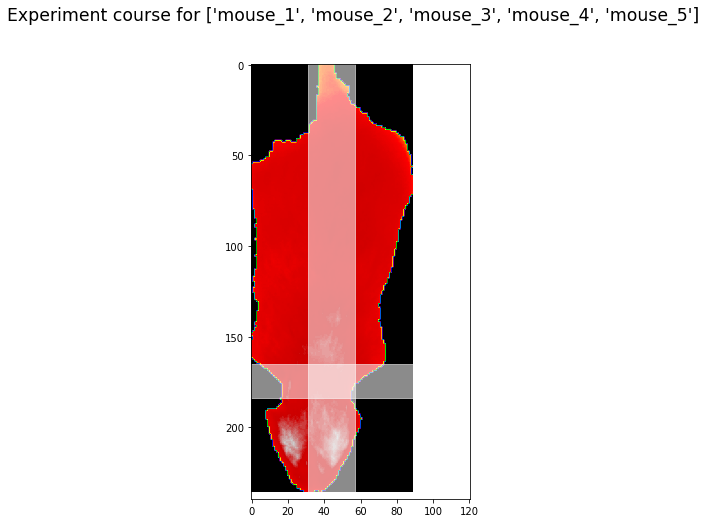

In [5]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t=f'Experiment course for {mouse_names}', fontsize='xx-large')
grid = fig.add_gridspec(nrows=1, ncols=1, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])

mean_roi_temp = []
roi_area_area = []
std_roi = []

mean_temp = []
std_temp = []

camera = Camera(fig)
print(f'{mouse_names}')
for i, (csv_image) in tqdm(enumerate(new_csv_thermals)):
    ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(csv_image)
    intensityFeature = csv_image[ordinatesX, ordinatesY]
    mean_temp.append(intensityFeature.mean())
    std_temp.append(intensityFeature.std())
    xmin = int(0.35*csv_image.shape[1])
    xmax = int(0.65*csv_image.shape[1])
    ymin = int(0.70*csv_image.shape[0])
    ymax = int(0.78*csv_image.shape[0])
    roi_area = csv_image[ymin:ymax, xmin:xmax]
    std_roi.append(np.std(roi_area))
    mean_roi_temp.append(np.mean(roi_area))
    roi_area_area.append(roi_area.size)
    # print(f'sample: #{i}')
    print(f'Body : shape: {csv_image.shape}, area: {intensityFeature.size} Mean Temp: {np.mean(intensityFeature)}  Std Temp: {np.std(intensityFeature)}')
    print(f'Patch : shape: {roi_area.shape}, area: {roi_area.size} Mean Temp: {np.mean(roi_area)}  Std Temp: {np.std(roi_area)}')
    ax0.imshow(X=csv_image, cmap=plt.cm.nipy_spectral)
    # ax0.set_title(label=sample)
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)    
    fig.add_subplot(ax0)
    camera.snap()
animation = camera.animate(interval=100)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Παράδειγμα μιας segmented εικόνας

<AxesSubplot:title={'center':'object image'}>

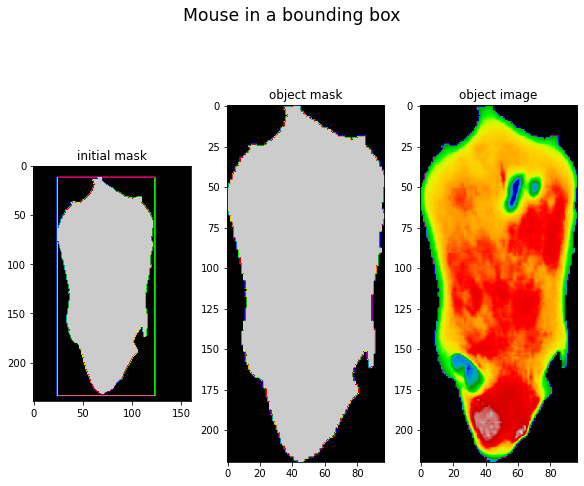

In [6]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
fig.suptitle(t='Mouse in a bounding box', fontsize='xx-large')
grid = fig.add_gridspec(nrows=1, ncols=3, wspace=0.2, hspace=0.25)

ax0 = fig.add_subplot(grid[0])
ax0.imshow(X=initial_masks[0], cmap=plt.cm.nipy_spectral)
ax0.set_title(label='initial mask')
fig.add_subplot(ax0)

ax1 = fig.add_subplot(grid[1])
ax1.imshow(X=object_masks[0], cmap=plt.cm.nipy_spectral)
ax1.set_title(label='object mask')
fig.add_subplot(ax1)

ax2 = fig.add_subplot(grid[2])
ax2.imshow(X=object_images[0], cmap=plt.cm.nipy_spectral)
ax2.set_title(label='object image')
fig.add_subplot(ax2)

### Εμφάνιση για όλες τις επιλεγμένες εικόνες χωρίς background

45it [00:00, 126.32it/s]


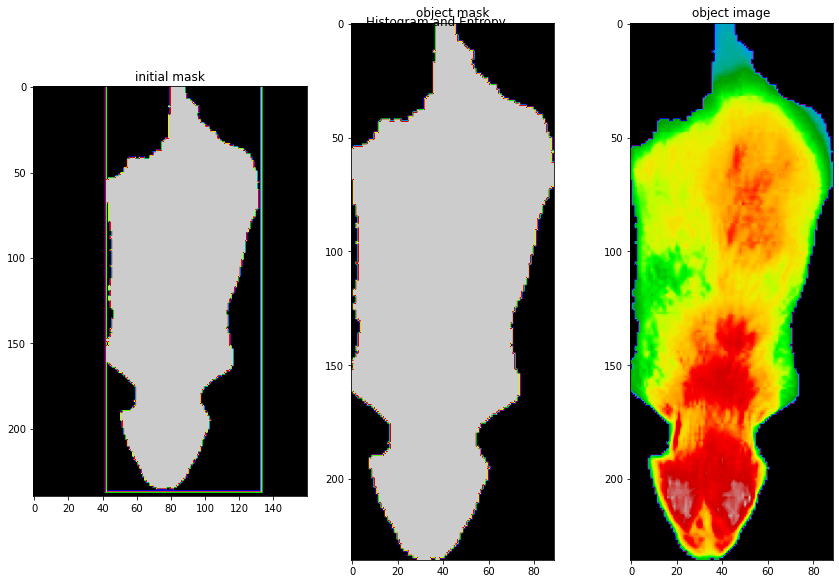

In [9]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
fig.suptitle(t='Histogram and Entropy')
grid = fig.add_gridspec(nrows=1, ncols=3, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
camera = Camera(fig)
for i, (initial_mask, object_mask, object_image) in tqdm(enumerate(zip(initial_masks, object_masks, object_images))):    
    ax0.imshow(X=initial_mask, cmap=plt.cm.nipy_spectral)
    ax0.set_title(label='initial mask')
    fig.add_subplot(ax0)
    ax1.imshow(X=object_mask, cmap=plt.cm.nipy_spectral)
    ax1.set_title(label='object mask')
    fig.add_subplot(ax1)
    ax2.imshow(X=object_image, cmap=plt.cm.nipy_spectral)
    ax2.set_title(label='object image')
    fig.add_subplot(ax2)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Γραφικές με τα ιστογράμματα και την εντροπία των εικόνων

45it [00:02, 21.84it/s]


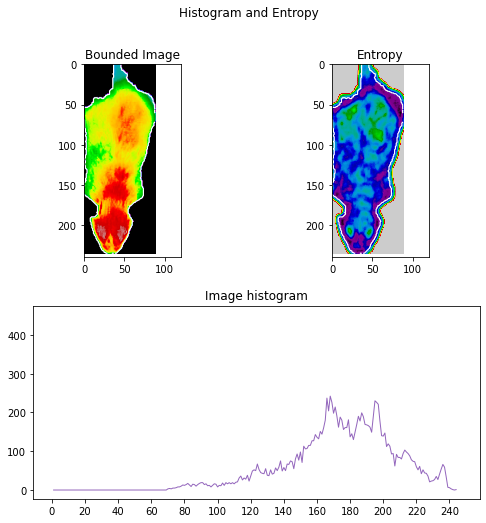

In [10]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram and Entropy')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[1, :])
object_images255 = [img_as_ubyte(object_image) for object_image in object_images]
camera = Camera(fig)
for i, (initial_mask, object_mask, object_image) in tqdm(enumerate(zip(initial_masks, object_masks, object_images255))):
    # ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(image)
    # intensityFeature = image[ordinatesX, ordinatesY]
    
    ax0.imshow(X=object_image, cmap=plt.cm.nipy_spectral)
    ax0.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    ax0.set_title(label='Bounded Image')
    # fig.colorbar(img0, ax=ax0)
    fig.add_subplot(ax0)

    ax1.imshow(X=entropy(image=object_image, selem=disk(5), mask=object_mask),
                      cmap=plt.cm.nipy_spectral_r)
    ax1.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    ax1.set_title(label='Entropy')
    # fig.colorbar(img1, ax=ax1)
    fig.add_subplot(ax1)

    hist, hist_centers = histogram(object_image)
    ax2.plot(hist_centers[1:], hist[1:], lw=1)
    ax2.set_title(label='Image histogram')
    ax2.set_xticks(ticks=np.arange(0, 255, 20))
    fig.add_subplot(ax2)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Γραφικές για τις εικόνες της Υφής και εξαγωγή Υφής

45it [00:05,  8.95it/s]


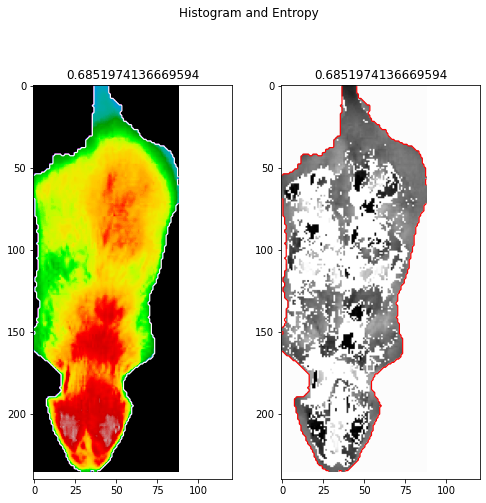

In [11]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram and Entropy')
grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
texture_images = []
camera = Camera(fig)
for i, (initial_mask, object_mask, object_image) in tqdm(enumerate(zip(initial_masks, object_masks, object_images))):
    # ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(image)
    # intensityFeature = image[ordinatesX, ordinatesY]
    ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(object_image)
    intensityFeature = object_image[ordinatesX, ordinatesY]
    ax0.imshow(X=object_image, cmap=plt.cm.nipy_spectral)
    ax0.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    ax0.set_title(label=intensityFeature.mean())
    fig.add_subplot(ax0)
    
    radius = 10
    n_points = 8 * radius + 4
    texture_image = local_binary_pattern(image=object_image, P=n_points, R=radius, method='uniform')
    texture_images.append(texture_image)
    ax1.imshow(X=texture_image, cmap=plt.cm.gray)
    ax1.contour(object_mask, [0.5], linewidths=1.2, colors='r')
    ax1.set_title(label=intensityFeature.mean())
    fig.add_subplot(ax1)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Γραφική για Ιστόγραμμα και εικόνα Εντροπίας

45it [00:07,  6.36it/s]


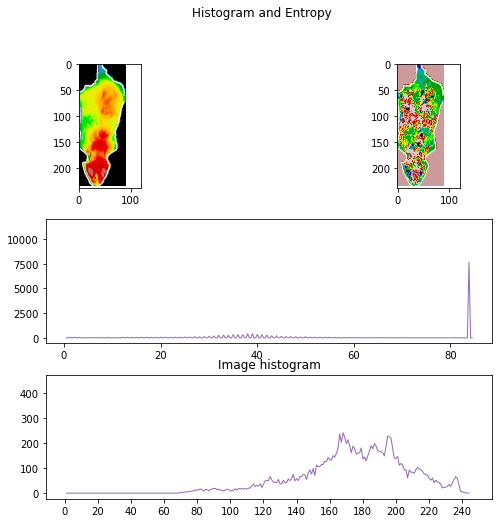

In [14]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram and Entropy')
grid = fig.add_gridspec(nrows=3, ncols=3, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 2])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])
camera = Camera(fig)
for i, (texture_image, object_mask, object_image) in tqdm(enumerate(zip(texture_images, object_masks, object_images))):
    # ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(image)
    # intensityFeature = image[ordinatesX, ordinatesY]
    ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(object_image)
    intensityFeature = object_image[ordinatesX, ordinatesY]
    ax0.imshow(X=object_image, cmap=plt.cm.nipy_spectral)
    ax0.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    fig.add_subplot(ax0)
    
    radius = 10
    n_points = 8 * radius + 4
    texture_image = local_binary_pattern(image=object_image, P=n_points, R=radius, method='uniform')
    texture_images.append(texture_image)
    ax1.imshow(X=texture_image, cmap=plt.cm.nipy_spectral)
    ax1.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    fig.add_subplot(ax1)
    
    histTexture, hist_centersTexture = histogram(texture_image)
    ax2.plot(hist_centersTexture[1:-1], histTexture[1:-1], lw=1)
    fig.add_subplot(ax2)
        
    hist, hist_centers = histogram(img_as_ubyte(object_image))
    ax3.plot(hist_centers[1:], hist[1:], lw=1)
    ax3.set_title(label='Image histogram')
    ax3.set_xticks(ticks=np.arange(0, 255, 20))
    fig.add_subplot(ax3)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Υπολογισμός clustering scores για όλο το σώμα και την τετραγωνική περιοχή

45it [05:07,  6.83s/it]


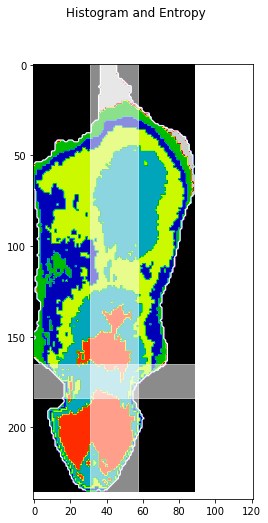

In [17]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram and Entropy')
grid = fig.add_gridspec(nrows=1, ncols=1, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
n_clusters = 6
scores = []
roi_scores = []
roi_labeled_images = []
roi_images = []
camera = Camera(fig)
for i, (texture_image, object_mask, object_image) in tqdm(enumerate(zip(texture_images, object_masks, object_images))):
    ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(object_image)
    n_samples = ordinatesX.size
    texture_feature = texture_image[ordinatesX, ordinatesY]
    intensity_feature = object_image[ordinatesX, ordinatesY]
    X = np.vstack((texture_feature, intensity_feature))
    # X = intensityFeature.reshape(-1, 1)
    # αν κανουμε clustering με το intensity ως feature
    # δηλαδή np.vstack((intensityFeature)) => (n_feature = 1)
    # τότε να κάνεις σχόλιο την παρακάτω γραμμή γιατί αλλιώς μπερδεύει τις διαστάσεις του Χ
    X = X.transpose()
    #--------------- 2a Feature Scaling Methods ---------------------------------
    scaler = preprocessing.RobustScaler()
    X = scaler.fit_transform(X)
    # tweaking the hyperparameter
    lamdaHyperparameter = 20.0
    X[:, 1] = np.sqrt(lamdaHyperparameter) * X[:, 1]
    kMeans = cluster.KMeans(n_clusters=n_clusters)
    kMeans.fit(X)
    CENTROIDS = kMeans.cluster_centers_.squeeze() # no random init at next iteration
    # print('Distance-based mouse centroids are ', CENTROIDS)
    labels = kMeans.labels_
    labeled_image = np.zeros_like(object_image, dtype='int')
    for i in range(n_samples):
        labeled_image[ordinatesX[i]][ordinatesY[i]] = labels[i] + 1
    xmin = int(0.35*object_image.shape[1])
    xmax = int(0.65*object_image.shape[1])
    ymin = int(0.70*object_image.shape[0])
    ymax = int(0.78*object_image.shape[0])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)    
    ax0.imshow(X=labeled_image, cmap=plt.cm.nipy_spectral)
    ax0.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    fig.add_subplot(ax0)
    
    roi_intensity_image = object_image[ymin:ymax, xmin:xmax]
    roi_texture_image = texture_image[ymin:ymax, xmin:xmax]
    roi_ordinatesX, roi_ordinatesY = img_to_vectors.img_to_vectors(roi_intensity_image)
    
    roi_intensity_feature = roi_intensity_image[roi_ordinatesX, roi_ordinatesY]
    roi_texture_feature = roi_texture_image[roi_ordinatesX, roi_ordinatesY]
    X_roi = np.vstack((roi_texture_feature, roi_intensity_feature))
    X_roi = X_roi.transpose()
    roi_labeled_image = labeled_image[ymin:ymax, xmin:xmax]
    roi_labeled_images.append(roi_labeled_image)
    roi_labels = roi_labeled_image[roi_ordinatesX, roi_ordinatesY]
    
    score = (silhouette_score(X, labels),
         calinski_harabasz_score(X, labels),
         davies_bouldin_score(X, labels))
    scores.append(score)
    roi_score = (silhouette_score(X_roi, roi_labels),
         calinski_harabasz_score(X_roi, roi_labels),
         davies_bouldin_score(X_roi, roi_labels))
    roi_scores.append(roi_score)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Clustering Scores για όλο το σώμα και την περιοχή ενδιαφέροντος

In [23]:
area_sil, area_ch, area_db = map(list, zip(*scores))
roi_sil, roi_ch, roi_db = map(list, zip(*roi_scores))

In [25]:
sil_roi = pd.DataFrame(np.reshape(roi_sil, (9, 5)), columns=experiment['mouse_id'], index=experiment['samples'])
ch_roi = pd.DataFrame(np.reshape(roi_ch, (9, 5)), columns=experiment['mouse_id'], index=experiment['samples'])
db_roi = pd.DataFrame(np.reshape(roi_db, (9, 5)), columns=experiment['mouse_id'], index=experiment['samples'])

sil_area = pd.DataFrame(np.reshape(area_sil, (9, 5)), columns=experiment['mouse_id'], index=experiment['samples'])
ch_area = pd.DataFrame(np.reshape(area_ch, (9, 5)), columns=experiment['mouse_id'], index=experiment['samples'])
db_area = pd.DataFrame(np.reshape(area_db, (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])

In [27]:
display('sil_roi', 'sil_area')

sil_roi
       mouse_1   mouse_2   mouse_3   mouse_4   mouse_5
0h   -0.515876 -0.311317  0.293672  0.051155  0.139016
24h  -0.182342 -0.157714 -0.496950  0.097861 -0.112705
48h   0.121718 -0.239529 -0.112285 -0.226893 -0.072006
72h  -0.183248 -0.177096  0.025339 -0.548854 -0.249886
96h  -0.213358 -0.146262  0.019963 -0.537533  0.004537
120h -0.450543  0.068853 -0.120066 -0.570623 -0.038689
144h  0.423195  0.270643 -0.387154 -0.000146  0.066411
192h -0.204466 -0.003507  0.279539 -0.070092 -0.302001
240h  0.345896  0.317119 -0.045384 -0.395724  0.219725

sil_area
       mouse_1   mouse_2   mouse_3   mouse_4   mouse_5
0h    0.480609  0.437134  0.447185  0.449616  0.422358
24h   0.424385  0.441413  0.455868  0.434764  0.459350
48h   0.431881  0.420550  0.442709  0.450038  0.436134
72h   0.438678  0.440660  0.443268  0.418710  0.424936
96h   0.438444  0.440505  0.445795  0.437051  0.418513
120h  0.437108  0.465572  0.427451  0.403966  0.465075
144h  0.424684  0.438083  0.443715  0.447952  0.419877
192h  0.446112  0.417937  0.435715  0.404301  0.427489
240h  0.421420  0.425171  0.450994  0.413460  0.459949

In [28]:
display('db_roi', 'db_area')

db_roi
        mouse_1     mouse_2    mouse_3    mouse_4    mouse_5
0h     3.874826    3.594120   1.977985   3.392964   2.941319
24h   22.719250  114.411258   8.259485  30.883969   4.759712
48h    3.137314    9.903609   4.227975   8.339452   4.910893
72h   15.333698    2.879082   2.204349  12.918439  14.717362
96h    8.463842    3.189008  15.209222   3.035353  15.747960
120h  21.634157    6.693719   3.956423  21.465025  23.919987
144h  23.605709    8.560336  22.713307  12.129811   8.736072
192h   3.500704   10.531706   8.713191   7.358386   8.259873
240h   1.791774   22.827021   5.274931   3.129926  11.766954

db_area
       mouse_1   mouse_2   mouse_3   mouse_4   mouse_5
0h    0.608241  0.644449  0.775138  0.692240  0.741768
24h   0.711365  0.726403  0.725007  0.791272  0.722900
48h   0.711480  0.726294  0.688503  0.646940  0.799095
72h   0.673160  0.691143  0.685300  0.732949  0.734362
96h   0.738941  0.663034  0.707662  0.703960  0.727584
120h  0.742213  0.706246  0.684608  0.711642  0.747835
144h  0.728733  0.721586  0.757896  0.673445  0.653616
192h  0.669846  0.706946  0.698459  0.740962  0.787522
240h  0.712487  0.713535  0.665421  0.704283  0.638752

In [32]:
display('ch_roi', 'ch_area')

ch_roi
         mouse_1    mouse_2     mouse_3     mouse_4     mouse_5
0h      9.458984  23.649991  117.644200  125.629736    3.616979
24h    40.937922  55.989545    5.656329   40.754367   20.900723
48h   116.390264   2.419894   58.438436   33.561868  151.644502
72h    31.821065  79.153062   57.488655    1.236244    9.374205
96h    53.291982  79.016461   28.039065   44.857967   64.725409
120h   14.476637  36.758218  117.614923    9.675399   46.044470
144h  337.137543  43.851789    3.945068   13.686183    2.666126
192h    5.481410  19.321683   94.143043   26.958105   21.143179
240h  123.466679  50.022648   39.118652  140.236345   61.322114

ch_area
           mouse_1       mouse_2       mouse_3       mouse_4       mouse_5
0h    42178.353713  49967.664485  41804.816677  56899.841460  42206.765808
24h   51476.593006  60319.532511  43350.924570  46951.354182  42415.872110
48h   47237.981155  42265.526249  42633.680463  40285.083746  43626.697285
72h   55160.214236  39776.148574  48367.553706  44120.815150  47704.617949
96h   46145.396850  39617.061260  38804.833931  39064.960305  43628.254611
120h  41517.945118  45707.129428  35985.836864  39151.856235  46256.750710
144h  43196.315715  45182.233390  50312.769985  44649.997810  43673.868092
192h  49903.445979  42339.961511  48239.175340  44438.514453  51252.581637
240h  41694.733446  46388.332537  40782.688182  43622.268610  36220.905788